# Clustering evaluation

In this notebook, we visually inspect the clustering assignments.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
import os

import numpy as np

from yass.neuralnet import NeuralNetDetector
from yass.config import Config

from neural_clustering.explore import (SpikeTrainExplorer,
                                       RecordingExplorer)
from neural_clustering import config


import matplotlib.pyplot as plt

/home/eduardo/miniconda3/envs/noise/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 15)

In [3]:
logging.basicConfig(level=logging.ERROR)

# Experiment to evaluate

In [2]:
EXPERIMENT_NAME = '29-Nov-2017@12-02-58-GMM'

# Loading configuration files and YASS output

In [4]:
# load configuration files
cfg_yass = Config.from_yaml('../yass_config/server_7ch.yaml')
cfg = config.load('../server_config.yaml')

In [5]:
# load data generated from yass
files = ['score', 'clear_index', 'spike_times', 'spike_train', 'spike_left', 'templates']

(score, clear_index,
 spike_times, spike_train,
 spike_left, templates) = [np.load(os.path.join(cfg['root'], 'yass/{}.npy'.format(f))) for f in  files]

In [6]:
score.shape, clear_index.shape, spike_times.shape, spike_left.shape, templates.shape

((7,), (7,), (7,), (7,), (7, 31, 17))

# Loading raw recordings, geometry file and projection matrix

In [7]:
# load standarized recordings (these are raw recordings + filter + standarization)
path_to_recordings = os.path.join(cfg_yass.root, 'tmp/standarized.bin')
# load gemetry file (position for every electro)
path_to_geometry = os.path.join(cfg_yass.root, cfg_yass.geomFile)

In [8]:
# load projection matrix (to reduce dimensionality)
proj = NeuralNetDetector(cfg_yass).load_w_ae()

# Load clustering results and clear spike times

We load the clustering assignments from the experiment

In [11]:
clusters = np.load(os.path.join(cfg['root'], 'sessions', EXPERIMENT_NAME, 'clusters.npy'))
clear_spikes = np.load(os.path.join(cfg['root'], 'clear_spikes.npy'))
results = np.vstack([clear_spikes, clusters]).T
group_ids = np.unique(clusters)

# Initializing explorers

These helper classes contain several functions for plotting results.

In [13]:
# initialize explorers, these objects implement functions for plotting
# the output from YASS
explorer_rec = RecordingExplorer(path_to_recordings,
                                 path_to_geometry,
                                 dtype='float64',
                                 window_size=cfg_yass.spikeSize,
                                 n_channels=cfg_yass.nChan,
                                 neighbor_radius=cfg_yass.spatialRadius)

explorer_train = SpikeTrainExplorer(templates,
                                    results,
                                    explorer_rec,
                                    proj)

# Templates

Build templates from clusters: take every point in each cluster, get the original waveform (31 temporal observations x 7 channels) and average all elements. Then plot the templates.

In [14]:
def make_template(group_id):
    wfs = explorer_train.waveforms_for_group(group_id=group_id, channels=range(7))
    return np.average(wfs, axis=0)

In [15]:
templates_new = np.stack([make_template(group_id) for group_id in group_ids]).transpose(2, 1, 0)

In [16]:
explorer_train = SpikeTrainExplorer(templates_new,
                                    results,
                                    explorer_rec,
                                    proj)

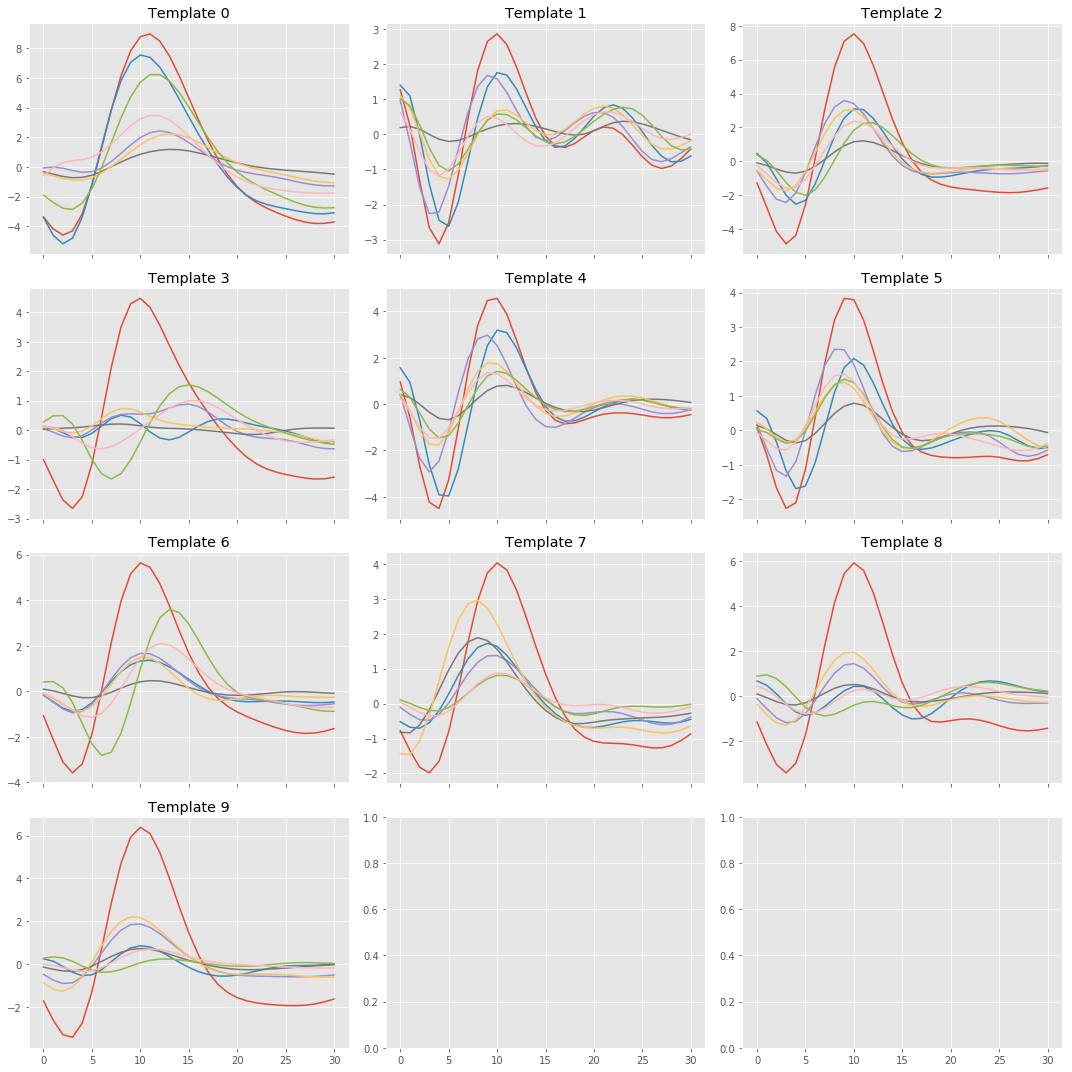

In [17]:
plt.rcParams['figure.figsize'] = (15, 15)
explorer_train.plot_templates(group_ids=group_ids)

## Cluster plots

Plot nehgboring clusters: get all the templates, compute the similarity among them (by comparing the squared difference in each temporal observation in each channel)

Then for every template, get the two most similar templates, find the cluster id for each and get the cluster elements for that cluster id.

Project all the points in the three clusters using LDA and plot.

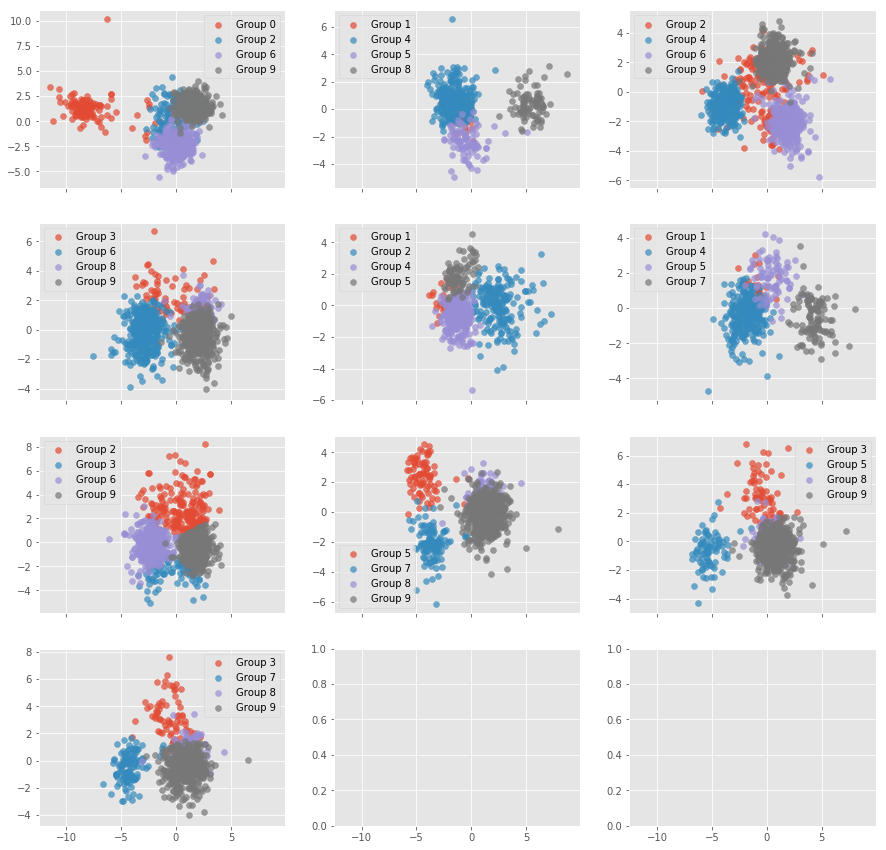

In [18]:
plt.rcParams['figure.figsize'] = (15, 15)
explorer_train.plot_all_clusters(k=3)

## Plotting specific groups

Plot 3 similar clusters along with the template for each group.

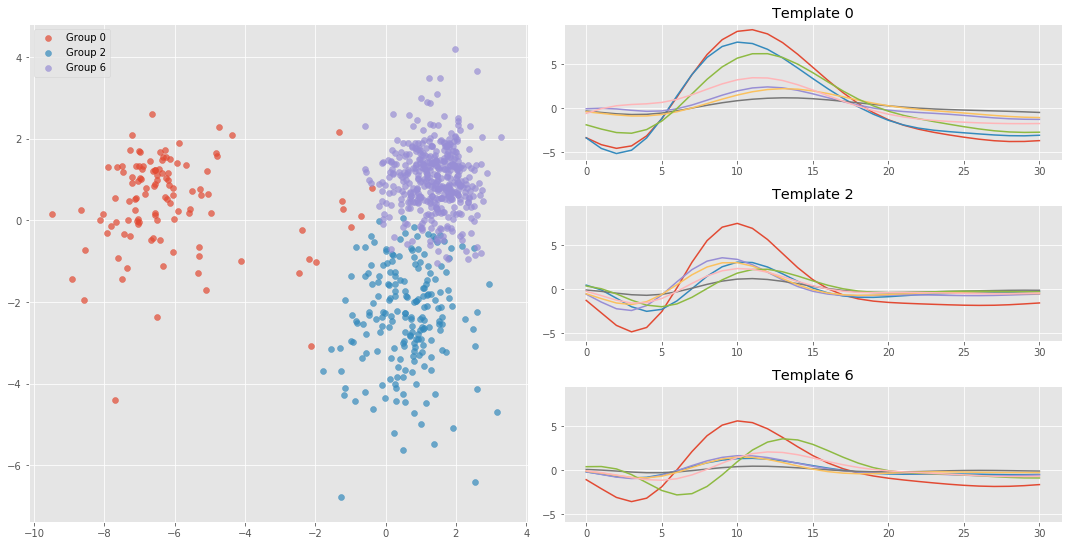

In [19]:
explorer_train.plot_waveforms_and_clusters(group_id=0)